# Relational Analysis

Using encodings generated by USE ML v3 encoder for:

- Constitution segments
- CCP reference topics (concatenated label and descriptions)
- Comparison topic sets (concatenated label and descriptions)

Analysis is based on topic-segment matrices generated during ontology processing.


In [1]:
__author__      = 'Roy Gardner'
__copyright__   = 'Copyright 2025, Roy and Sally Gardner'

%run ./_library/packages.py
%run ./_library/utilities.py

exclusion_list = ['segment_encodings.json','IDEA-GLO_topic_encodings.json','CCP-FACET_topic_encodings.json',\
                     'NC-DCC_topic_encodings.json']
_,model_dict = initialise(exclusion_list=exclusion_list)


Initialisation started…
Finished initialisation.


## Map segments onto tagged topics

In [2]:
# Invert the sat_segments_dict

segments_lookup = {}
for k,v in model_dict['sat_segments_dict'].items():
    for segment_id in v:
        if segment_id in segments_lookup:
            segments_lookup[segment_id].append(k)
        else:
            segments_lookup[segment_id] = [k]


## Reference ontology matrices

From $\mathbf{A}^{r,s}$ provides thresholded and binarised matrix:
- $\mathbf{B}^{r,s}$


In [3]:
threshold = 0.70

ref_labels = [v['encoded_text'] for k,v in model_dict['CCP-FACET_topics_dict'].items()]

A = np.array(model_dict['CCP-FACET_topic_segment_matrix'])
B = np.where(A>=threshold,1,0).astype(int)


## Run the comparisons

For each comparison ontology's $\mathbf{C}^{c,s}$ matrix provides thresholded and binarised matrix:
- $\mathbf{D}^{c,s}$

and co-occurrence matrix:
- $\mathbf{E}^{c,r}$

Outputs results to CSV.

### Validation

All CCP segments assigned to a comparison topic must be an empty column in matrix $\mathbf{B}^{r,s}$.



In [4]:
comparison_matrices = ['IDEA-GLO_topic_segment_matrix','NC-DCC_topic_segment_matrix']
comparison_dicts = ['IDEA-GLO_topics_dict','NC-DCC_topics_dict']

for i,matrix_label in enumerate(comparison_matrices):
    comp_labels = [v['encoded_text'] for k,v in model_dict[comparison_dicts[i]].items()]
    
    C = np.array(model_dict[matrix_label])
    # Threshold and binarise
    D = np.where(C>=threshold,1,0).astype(int)
    
    E = np.matmul(D,B.T)
    
    segments_set = []

    csv_row_list = []
    header = []
    header.append('idea_topic')
    header.append('segment_id')
    header.append('segment_text')
    header.append('tagged_ccp_topics')
    csv_row_list.append(header)
    # Search for empty rows
    for i,row in enumerate(E):
        if row.nonzero()[0].size == 0:
            # Get at- or above-threshold segments from the topic's row in matrix D
            segment_indices = [j for j,v in enumerate(D[i]) if v==1]
            if len(segment_indices) == 0:
                # No segments so explains why row in matrix E is empty
                continue
            for j in segment_indices[0:10]:
                csv_row = []
                csv_row.append(comp_labels[i])
                segment_id = model_dict['encoded_segments'][j]
                segments_set.append(segment_id)
                segment_text = model_dict['segments_dict'][segment_id]['text']
                csv_row.append(segment_id)
                csv_row.append(segment_text)
                if segment_id in segments_lookup:
                    csv_row.append(str(segments_lookup[segment_id]))
                else:
                    csv_row.append('')
                csv_row_list.append(csv_row)
                
    file_label = matrix_label.split('_')[0]
    with open('./outputs/' + file_label + '_candidates.csv', 'w') as f:
        writer = csv.writer(f)
        writer.writerows(csv_row_list)
    f.close() 
    
    segments_set = list(set(segments_set))

    n = 0
    for segment_id in segments_set:
        segment_index = model_dict['encoded_segments'].index(segment_id)
        if B[:,segment_index].nonzero()[0].size == 0:
            n += 1
    assert(len(segments_set)==n)       
    print('Validated',len(segments_set),'segments for',file_label)


    print()
    print('Data exported to CSV file:','./outputs/' + file_label + '_candidates.csv')
    print()


Validated 256 segments for IDEA-GLO

Data exported to CSV file: ./outputs/IDEA-GLO_candidates.csv

Validated 501 segments for NC-DCC

Data exported to CSV file: ./outputs/NC-DCC_candidates.csv



## Observed-Expected Metric

In [65]:
comparison_matrices = ['IDEA-GLO_topic_segment_matrix']
comparison_dicts = ['IDEA-GLO_topics_dict']

for i,matrix_label in enumerate(comparison_matrices):
    comp_labels = [v['encoded_text'] for k,v in model_dict[comparison_dicts[i]].items()]
    
    C = np.array(model_dict[matrix_label])
    # Threshold and binarise
    D = np.where(C>=threshold,1,0).astype(int)
    
    E = np.matmul(D,B.T)


314
136
177


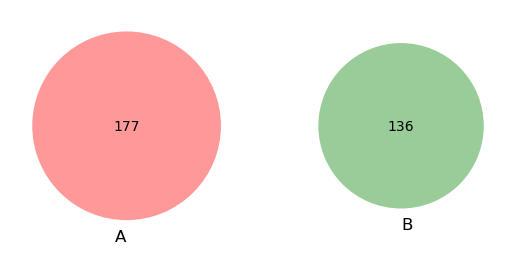

In [79]:
def get_expected_matrix(matrix):
    # Expected matrix assuming independence of topic sets
    rows_marginal = matrix.sum(axis=1)
    cols_marginal = matrix.sum(axis=0)
    matrix_total = matrix.sum()
    
    # Calculate matrix of expected values under independence
    expected = np.outer(rows_marginal,cols_marginal)/matrix_total
    return expected

def get_associations(matrix,threshold):
    # Get indices of cells above threshold
    indices = np.where(matrix >= threshold)
    return indices

def get_unassociated(matrix):
    # Get indices of cells above threshold
    indices = np.where(matrix == -1)
    return indices

def get_expected_association(matrix):
    # Get indices of cells above threshold
    indices = np.where(matrix == 0.0)
    return indices
    
expected_matrix = get_expected_matrix(E) 
# Calculate observed - expected (O-E)
diff_matrix = E - expected_matrix

# Calculate normalized difference (O-E)/E
with np.errstate(divide='ignore', invalid='ignore'):
    ratio_matrix = diff_matrix/expected_matrix
    # Handle division by zero
    ratio_matrix = np.nan_to_num(ratio_matrix, nan=0, posinf=np.inf, neginf=-np.inf)

#indices = get_associations(ratio_matrix,1.0)
#print(len(indices[0]))

#indices = get_expected_association(ratio_matrix)
#print(len(indices[0]))

indices = get_unassociated(ratio_matrix)
#print(len(indices[0]))

un_comp_labels = set([comp_labels[row_index] for row_index in indices[0]])

empty_comp_labels = []
for row_index,row in enumerate(E):
    if row.nonzero()[0].size == 0:
        empty_comp_labels.append(comp_labels[row_index])
        
print(len(comp_labels))
print(len(un_comp_labels))
print(len(empty_comp_labels))

venn2([set(empty_comp_labels),set(un_comp_labels)])
plt.show()
